# Design Process

Dynamics of Railway Bridges Ch. 8 - See "Dynamics of Railway Bridges" notebook

AREMA References:
Chapter 30 - 1.5 (Longitudinal Load)



In [1]:
%pip show civilpy

Name: civilpy
Version: 0.0.94
Summary: Civil Engineering Tools in Python
Home-page: https://daneparks.com/Dane/civilpy
Author: Dane Parks
Author-email: Dane@daneparks.com
License: MIT
Location: c:\users\dane.parks\appdata\local\anaconda3\envs\lab\lib\site-packages
Requires: beautifulsoup4, coverage, fiona, Flask, folium, geopandas, html5lib, icalendar, msedge-selenium-tools, natsort, numpy, openpyxl, pandas, Pillow, Pint, PyMuPDF, pyntcloud, PyPDF2, pytesseract, pytest, pytest-cov, requests, sshtunnel, sympy, termcolor, tifftools, tqdm, webdriver-manager
Required-by: 
Note: you may need to restart the kernel to use updated packages.


## Analysis Loads

All calculations were done utilizing Cooper's E80 loading, defined below,

In [2]:
from civilpy.structural.arema import CooperE80
from civilpy.general import units
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

from typing import List, Tuple
from dataclasses import dataclass

Output directory already exists


In [3]:
# for Cooper E80
cooper_e80 = CooperE80()

In [4]:
print(cooper_e80)

0 foot: 40 kip
8 foot: 80 kip
13 foot: 80 kip
18 foot: 80 kip
23 foot: 80 kip
32 foot: 52 kip
37 foot: 52 kip
43 foot: 52 kip
48 foot: 52 kip
56 foot: 40 kip
64 foot: 80 kip
69 foot: 80 kip
74 foot: 80 kip
79 foot: 80 kip
88 foot: 52 kip
93 foot: 52 kip
99 foot: 52 kip
104 foot: 52 kip
109 foot: 8.0 kip / foot


In [5]:
dir(cooper_e80)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'distances',
 'distributed',
 'magnitudes',
 'series',
 'spacing']

## Coopers as a Series of Distributed Loads

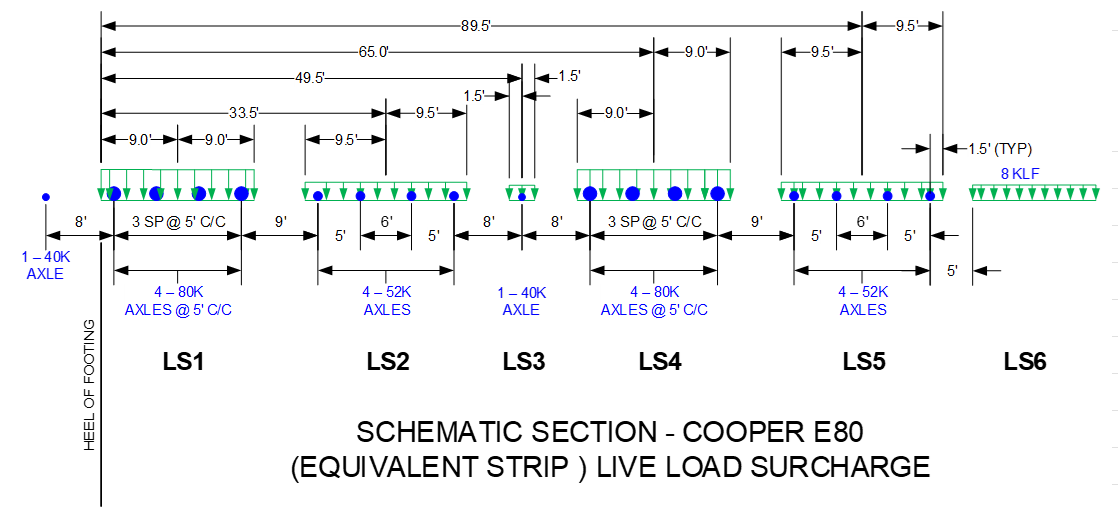

In [6]:
class CooperE80EqStrip:
    """
    Class to represent Cooper's E80 loading as a series of distributed loads.

    Currently ignores the front 40k axel and starts with the first 80K axel in order to align with Geotech teams calculations done up
    to this point as well as extending the loads 1.5' in front of and behind each axel.

    #//TODO - Will potentially update to be a more exact distributed load in line with Coopers definition
    """

    def __init__(self, length_of_train=150 * units.ft):
        self.tie_width: float = 8.5 * units.ft  # feet for single tie length
        self.distances: list[int] = [
            x * units.feet
            for x in [
                0,
                18,  # LS1 # Displayed this way to show paired distances
                24,
                43,  # LS2
                48,
                51,  # LS3
                56,
                74,  # LS4
                80,
                99,  # LS5
                102.5,  # LS6
            ]
        ]
        self.magnitudes: list[int] = [
            x
            for x in [
                80
                * units.kips
                * 4
                / ((self.distances[1] - self.distances[0]) * self.tie_width),  # LS1
                52
                * units.kips
                * 4
                / ((self.distances[3] - self.distances[2]) * self.tie_width),  # LS2
                40
                * units.kips
                * 1
                / ((self.distances[5] - self.distances[4]) * self.tie_width),  # LS3
                80
                * units.kips
                * 4
                / ((self.distances[7] - self.distances[6]) * self.tie_width),  # LS4
                52
                * units.kips
                * 4
                / ((self.distances[9] - self.distances[8]) * self.tie_width),  # LS5
                8
                * units("kips/ft")
                * (length_of_train - self.distances[10])
                / ((length_of_train - self.distances[10]) * self.tie_width),  # LS6
            ]
        ]
        self.linear_loads = {
            "LS1": (
                self.distances[0],
                self.distances[1],
                self.magnitudes[0] * self.tie_width,
            ),
            "LS2": (
                self.distances[2],
                self.distances[3],
                self.magnitudes[1] * self.tie_width,
            ),
            "LS3": (
                self.distances[4],
                self.distances[5],
                self.magnitudes[2] * self.tie_width,
            ),
            "LS4": (
                self.distances[6],
                self.distances[7],
                self.magnitudes[3] * self.tie_width,
            ),
            "LS5": (
                self.distances[8],
                self.distances[9],
                self.magnitudes[4] * self.tie_width,
            ),
            "LS6": (
                self.distances[10],
                length_of_train,
                self.magnitudes[5] * self.tie_width,
            ),
        }

In [7]:
# Example usage:
# Initialize the class with sample data
cooper_e80 = CooperE80EqStrip()

[print(f"{cooper_e80.linear_loads[key]}\n") for key in cooper_e80.linear_loads];

(<Quantity(0, 'foot')>, <Quantity(18, 'foot')>, <Quantity(17.7777778, 'kip / foot')>)

(<Quantity(24, 'foot')>, <Quantity(43, 'foot')>, <Quantity(10.9473684, 'kip / foot')>)

(<Quantity(48, 'foot')>, <Quantity(51, 'foot')>, <Quantity(13.3333333, 'kip / foot')>)

(<Quantity(56, 'foot')>, <Quantity(74, 'foot')>, <Quantity(17.7777778, 'kip / foot')>)

(<Quantity(80, 'foot')>, <Quantity(99, 'foot')>, <Quantity(10.9473684, 'kip / foot')>)

(<Quantity(102.5, 'foot')>, <Quantity(150, 'foot')>, <Quantity(8.0, 'kip / foot')>)



# Geotechnical Calculation Methods

## Rankine

$$ P_a = \frac{1}{2} \gamma H^2 K_a $$

Where;

$ \gamma $ = unit weight of the soil (in kN/m³ or lb/ft³)
$ H $ = height of the abutment (in meters or feet)
$ K_a $ = active earth pressure coefficient

The active earth pressure coefficient $ K_a $ for a granular soil (assuming a horizontal backfill) can be calculated using:

$$ K_a = \tan^2 \left( 45^\circ - \frac{\phi}{2} \right) $$

Where;

$\phi$ = internal friction angle of the soil (in degrees)

In [8]:
from civilpy.geotechnical import rankine_active_pressure

define inputs;

In [9]:
# Example usage:
unit_weight = 18.0  # kN/m³
height = 5.0  # meters
friction_angle = 30.0  # degrees

calculation;

In [10]:
active_pressure = rankine_active_pressure(unit_weight, height, friction_angle)
print(f"Active earth pressure: {active_pressure:.2f} kN/m²")

Active earth pressure: 75.00 kN/m²


### Breakdown of Excel Sheet Process

**Assumptions**

- Due to the limit of Culmann's solution, this solution only applies to an effective stress state. Additionally the soil angle of internal friction and unit weight must be the same throughout the soil mass.																

- Where layered soils are present, use an idealized soil profile based on a weighted average of the soil parameters. 																
    - Fill and Existing Soils present - use weighted average for $\phi = 32*\frac{10.9}{23.9} + 28*\frac{13}{23.9}$ and $\gamma = 115*\frac{10.9}{23.9} + 120*\frac{13}{23.9}$															
- LL Surcharge is calculated based on E80 loading; each axle group is modeled as am idealized as a strip load. (see Figure)																
    - Load is assumed to be in line with the backwall															
    - Bottom of the track tie is at top of wall elevation.															
    - Uniformly distribute the closely spaced axle loads over a length equal to the distance between the outer most axles plus 3 feet, e.g., for LS5, the length for uniform load is 19 feet = 1.5 + 5 + 6 + 5 + 1.5.  This is consistent with AREMA Chapter 8 Section 2.2.3.c.(2).															
    - Axles groups within a distance (x) that is at least equal to the wall height (y) will be analyzed.															
																
```
    LS1 = 	(80K * 4 axles) / (18-ft * 8.5-ft) = 			2091.5	ksf										
	LS2 = 	(52K * 4 axles) / (19-ft * 8.5-ft) = 			1287.9	ksf										
	LS3 = 	(40K * 1 axle) / (3-ft * 8.5-ft) = 			1568.6	ksf										
	LS4 = 	(80K * 4 axles) / (18-ft * 8.5-ft) = 			2091.5	ksf
```
 
- See Lpile Subsurface Profile Sketch for a summary of the subsurface conditions
- No interface friction between the backwall and the soils
- GWT is at top of weathered bedrock `=8*50/(8.5*50)`

**Analysis Steps for Culmann Graphical Solution**
																
1. Define the ground line by inputting coordinates of the points that will be used to form trial wedges.  Note, the coordinate of Point B is always (0,0).
2. For each Soil Wedge:
    1. Calculate the  length of each side, $a_i$, $b_i$, and $c_i$ in Figure 1.
    2. Calculate the area, $A_i$.
    3. Calculate the coordinates of center of gravity, $x_{cgi}$, $y_{cgi}$.
    4. Calculate the coordinates of cumulative center of gravity (center of gravity of the soil mass above and including Wedge No. i), $x_{ccgi}$, $y_{ccgi}$.
    5. Calculate the weight of the wedge, $w_i$.
    6. Calculate the cumulative weight of all soil wedges above and including Wedge No. i,
    7. Scale the cumulative weight based on user defined scale and calculate the coordinates of scaled W_i on Phi Line (Line BD in Figure 2a),  e.g. $Bc_i = W_i$.
    8. Calculate the coordinates of c'_i, where c_ic'_i is parallel to the line BE and c'_i is located on line BC_i.
    9. Calculate the distance from c'_i to the Phi Line (Line BD).
3. Find the Point c'_i that is farthest from the Phi Line (Line BD), name it c'_a and name the relevant point on Phi Line c_a.  This is equivalent to finding c'_a by drawing line B'D' in Figure 2a.
    **If $c_a$ turns out to be on the last assumed plane of rupture, revise input by moving the trial wedges further from the wall.  Otherwise, it may yield misleading results**
4. The critical plane of rupture is a line connecting B with c'_a.
5. The distance c'_ac_a is the scaled total thrust from active earth pressure.
6. Find the center of gravity of the sliding soil mass above the critical plane of rupture from the values calculated in Step 1.6.
7. Line of action is the line passing center of gravity of the sliding soil mass and parallel to the critical plane of rupture.
8. Calculate the coordinates of the point where Line of Action intercept back of wall.
9. Calculate active earth pressure coefficient.

In [26]:
soil_unit_weight = 117.7 * units("lbf/ft^3")
soil_angle_int_friction = 29.8 * units("degrees")
angle_back_wall_with_horizontal = 0 * units("degrees")
angle_of_wall_friction_delta = 0 * units("degrees")
angle_of_wall_friction_gamma = 90 * units("degrees")
load_scale = 2.9059 * units("kips/ft")
wall_height = 19.5
soil_height_above_wall = 4.4
num_slices = 19
total_length = 38
track_offset = 2

In [27]:
cooper_e80.linear_loads

{'LS1': (0 <Unit('foot')>,
  18 <Unit('foot')>,
  17.77777777777778 <Unit('kip / foot')>),
 'LS2': (24 <Unit('foot')>,
  43 <Unit('foot')>,
  10.947368421052632 <Unit('kip / foot')>),
 'LS3': (48 <Unit('foot')>,
  51 <Unit('foot')>,
  13.333333333333334 <Unit('kip / foot')>),
 'LS4': (56 <Unit('foot')>,
  74 <Unit('foot')>,
  17.77777777777778 <Unit('kip / foot')>),
 'LS5': (80 <Unit('foot')>,
  99 <Unit('foot')>,
  10.947368421052632 <Unit('kip / foot')>),
 'LS6': (102.5 <Unit('foot')>, 150 <Unit('foot')>, 8.0 <Unit('kip / foot')>)}

In [29]:
from civilpy.geotechnical.culmans import find_key_for_value_in_tuple_range

print(find_key_for_value_in_tuple_range(cooper_e80.linear_loads, 14))

LS1


In [30]:
# Coordinates
coordinates_list = {
    # "A": (0, wall_height, find_key_for_value_in_tuple_range(cooper_e80.linear_loads, 0)), # See Excel comment - overridden to match sheet
    "A": (0, 23.9, find_key_for_value_in_tuple_range(cooper_e80.linear_loads, 0)),
    "B": (0, 0, None),
}

# Build a list of C values based on the user input
for x in range(0, num_slices):
    coordinates_list[f"C_{x+1}"] = (
        x * (total_length / num_slices) + track_offset,
        wall_height + soil_height_above_wall,
        find_key_for_value_in_tuple_range(
            cooper_e80.linear_loads, x * total_length / num_slices
        ),
    )

In [ ]:
sample_data["coordinates_list"]

In [31]:
coordinates_list

{'A': (0, 23.9, 'LS1'),
 'B': (0, 0, None),
 'C_1': (2.0, 23.9, 'LS1'),
 'C_2': (4.0, 23.9, 'LS1'),
 'C_3': (6.0, 23.9, 'LS1'),
 'C_4': (8.0, 23.9, 'LS1'),
 'C_5': (10.0, 23.9, 'LS1'),
 'C_6': (12.0, 23.9, 'LS1'),
 'C_7': (14.0, 23.9, 'LS1'),
 'C_8': (16.0, 23.9, 'LS1'),
 'C_9': (18.0, 23.9, 'LS1'),
 'C_10': (20.0, 23.9, 'LS1'),
 'C_11': (22.0, 23.9, None),
 'C_12': (24.0, 23.9, None),
 'C_13': (26.0, 23.9, 'LS2'),
 'C_14': (28.0, 23.9, 'LS2'),
 'C_15': (30.0, 23.9, 'LS2'),
 'C_16': (32.0, 23.9, 'LS2'),
 'C_17': (34.0, 23.9, 'LS2'),
 'C_18': (36.0, 23.9, 'LS2'),
 'C_19': (38.0, 23.9, 'LS2')}

In [32]:
def plot_results():
    # Extract x and y coordinates
    x_coordinates = [value[0] for value in coordinates_list.values()]
    y_coordinates = [value[1] for value in coordinates_list.values()]

    # Coordinates for points A and B
    A_x, A_y = coordinates_list["A"][0], coordinates_list["A"][1]
    B_x, B_y = coordinates_list["B"][0], coordinates_list["B"][1]

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_coordinates, y_coordinates, marker="o", color="b")

    # Annotate the points
    for key, (x, y, label) in coordinates_list.items():
        plt.annotate(
            key, (x, y), textcoords="offset points", xytext=(0, 10), ha="center"
        )
        # Draw lines connecting 'C' points to 'B'
        if key.startswith("C"):
            plt.plot([B_x, x], [B_y, y], "g--")

    # Highlight points A and B
    plt.scatter(A_x, A_y, color="r", zorder=5)
    plt.scatter(B_x, B_y, color="r", zorder=5)

    # Create lists to store C points
    C_x_coords = [A_x]  # Start with point A
    C_y_coords = [A_y]  # Start with point A

    # Append only the C points
    for key, (x, y, label) in coordinates_list.items():
        if key.startswith("C"):
            C_x_coords.append(x)
            C_y_coords.append(y)

    # Plot the ground line connecting point A with all the C points
    plt.plot(C_x_coords, C_y_coords, "k-", label="Ground Line")

    # Define the retaining wall coordinates
    top_thickness = 1.5
    base_thickness = 2
    retaining_wall_x = [
        A_x,  # Top right
        A_x - top_thickness,  # Top left
        B_x - base_thickness,  # Bottom left
        B_x,  # Bottom right
    ]
    retaining_wall_y = [
        A_y,  # Top (same as point A)
        A_y,  # Top (same height as point A)
        B_y,  # Bottom (same as point B)
        B_y,  # Bottom (same height as point B)
    ]

    # Draw the retaining wall shape with a trapezoidal face
    plt.fill(
        retaining_wall_x, retaining_wall_y, "blue", alpha=0.3, label="Retaining Wall"
    )

    # Add legend
    plt.legend()

    # Define titles and labels
    plt.title("Retaining Wall Design - Culmann's Method")
    plt.xlabel("Feet")
    plt.ylabel("Feet")
    plt.grid(True)

    # Show the plot
    plt.show()

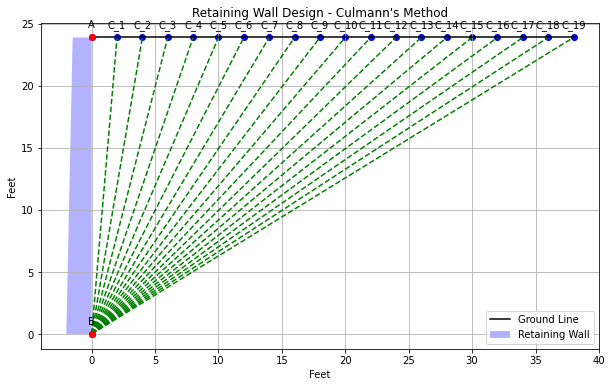

In [33]:
plot_results()

#### Calculate the Areas of the Soil Wedges

In [34]:
number_wedges = len(coordinates_list) - 3
number_wedges

18

#### Formulas Table (Rows 81-103)

| Category           | Column  | Math Formula                       |  Excel Formula (top row)  | Python Formula (first value 'A')                                            |
|:------------------:|:-------:|:----------------------------------:|:-------------------------:|:---------------------------------------------------------------------------:|
|  --------          |    B    | $ c_i = BC_{i-1} $                 |    =SQRT(C50^2+D50^2)     | c_i = math.sqrt(coordinates_list['A'][0]**2+coordinates_list['A'][1]**2     |
|     \|             |    C    | $ a_i = BC_i $                     |    =SQRT(C51^2+D51^2)     | a_i = math.sqrt(coordinates_list['C_1'][0]**2+coordinates_list['C_1'][1]**2 |
|     \|             |    D    | $ b_i = C_{i-1}C_i $               | =SQRT((C51-C50)^2+(D51-D50)^2) | b_i = math.sqrt(<br>(coordinates_list['A'][0]-coordinates_list['C_1'][0])**2+<br>(coordinates_list['A'][1]-coordinates_list['C_1'][1])**2<br>) |
|     \|             |    E    | $ s_i = (a_i+b_i+c_i)/2 $          |  =SUM(B86:D86)/2          | s_i = sum(c_i, a_i, b_i)\2                                                  |
|     \|             |         | $ \text{Area}^1 $                  |                           |                |
|     Dimension of   |    F    | $ A_i $                            | =SQRT(E86*(E86-B86)\*(E86-C86)\*(E86-D86)) | =math.sqrt(s_i * (s_i - c_i) * (s_i - a_i) * (s_i - b_i)   |
|    soil wedge      |         | $ \text{Center of gravity}^2 $     |                           |                |
|     \|             |    G    | $ x_cgi $                          | =(C50+C51)/3              | x_cgi = (coordinates_list['A'][0]+coordinates_list['C_1'][0])/3             |
|     \|             |    H    | $ y_cgi $                          | =(D50+D51)/3              | y_cgi = (coordinates_list['A'][1]+coordinates_list['C_1'][1])/3             |
|     \|             |         | $ \text{Cumulative Center of Gravity}^3 $ | (Second Row)       |                                                                             |
|     \|             |    I    | $ x_{ccgi} $                       | =(G87\*\\$K87+I86\*\\$L86)/\$L87 | x_ccgi = (x_cgi * w_i + x_ccgi-1 * W_i-1) / W_i                      |
|  --------          |    J    | $ y_{ccgi} $                       | =(H87\*\\$K87+J86\*\\$L86)/\$L87 | y_ccgi = (y_cgi * w_i + y_ccgi-1 * W_i-1) / W_i                      |
| inc. soil mass     |    K    | $ w_i $                            | =F86\*\\$M\$47            | w_i = a_i*soil_unit_weight                                                  |
| cum. soil mass     |    L    | $ W_i $                            |                           | W_i = sum(w_i)                                                              |
| LL surcharge       |    M    | Cumulative Surcharge               | =80000\*4/18/8.5\*D86     | ll_surcharge = sum(80000 * 4 / 18 / 8.5 * b_i)                              |
| Total weight       |    N    | Total Weight                       | =N86*(1/\\$M\\$54/1000)*COS(\\$P\\$48) | total_weight = W_i + ll_surcharge, max_total_weight = max(total_weight) |
| Scaled W on        |    O    | $ x_{ci} $                         | =N86*(1/\\$M\\$54/1000)*COS(\\$P\\$48) | x_ci = total_weight_i * (1/load_scale/1000)*cos(soil_angle_int_friction) |
| Phi Line$^6$       |    P    | $ y_{ci} $                         | =O86*TAN(Phi)                          | y_ci = x_ci * tan(soil_angle_int_friction)                     |
|  Cullman           |    Q    | $ x_{c'i} $                        | =(P86-TAN(PI()/2+Theta+Delta+Phi)*O86)/(D51/C51-TAN(PI()/2+Theta+Delta+Phi)) | x_c_prime_i = see code   |
|   Curve$^7$        |    R    | $ y_{c'i} $                        | =D51/C51*Q86                           | y_c_prime_i = coordinates_list['C_1'][1] / coordinates_list['C_1'][0] * x_c_prime_i |
| Length of Line$^8$ |    S    | $ c'_ic_i $                        | =IF(R86<Q86*k_Phi,-1,1)*SQRT((O86-Q86)^2+(P86-R86)^2) | c_prime_i_c_i = see code                        |

In [62]:
class CulmansMethod:
    def __init__(
        self,
        coordinates_list=coordinates_list,
        soil_unit_weight=117.7 * units("lbf/ft^3"),
        soil_angle_int_friction=29.8 * units("degrees"),
        angle_back_wall_with_horizontal=0 * units("degrees"),
        angle_of_wall_friction_delta=0 * units("degrees"),
        angle_of_wall_friction_gamma=90 * units("degrees"),
        load_scale=2.9059 * units("kips/ft"),
        wall_height=19.5 * units("ft"),
        soil_height_above_wall=4.4 * units("ft"),
        num_slices=19,
        total_length=38 * units("ft"),
        track_offset=2 * units("ft"),
    ):
        self.coordinates_list = coordinates_list
        self.soil_unit_weight = soil_unit_weight
        self.soil_angle_int_friction = soil_angle_int_friction
        self.angle_back_wall_with_horizontal = angle_back_wall_with_horizontal
        self.angle_of_wall_friction_delta = angle_of_wall_friction_delta
        self.angle_of_wall_friction_gamma = angle_of_wall_friction_gamma
        self.load_scale = load_scale
        self.wall_height = wall_height
        self.soil_height_above_wall = soil_height_above_wall
        self.num_slices = num_slices
        self.total_length = total_length
        self.track_offset = track_offset
        self.table = self.generate_spreadsheet(
            self.coordinates_list,
            self.soil_unit_weight,
            self.load_scale,
            self.soil_angle_int_friction,
            self.angle_back_wall_with_horizontal,
            self.angle_of_wall_friction_delta,
        )

    def calculate_a_i(self, x_val, y_val):
        """Calculate a_i (ft) based on the current coordinates."""
        result = np.sqrt((x_val * units.ft) ** 2 + (y_val * units.ft) ** 2)
        return result.to(units.ft).round(4)

    def calculate_c_i(self, current_key, keys, coordinates_list):
        """Calculate c_i (ft) based on the previous coordinates. If first point, refer to point 'A'."""
        if current_key == "C_1":
            prev_x_val, prev_y_val, _ = coordinates_list["A"]
        else:
            prev_x_val, prev_y_val, _ = coordinates_list[
                keys[keys.index(current_key) - 1]
            ]
        result = np.sqrt((prev_x_val * units.ft) ** 2 + (prev_y_val * units.ft) ** 2)
        return result.to(units.ft).round(4)

    def calculate_b_i(self, current_key, keys, coordinates_list, x_val, y_val):
        """Calculate b_i (ft) using the previous point's coordinates."""
        if current_key == "C_1":
            prev_x_val, prev_y_val, _ = coordinates_list["A"]
        else:
            prev_key = keys[keys.index(current_key) - 1]
            prev_x_val, prev_y_val, _ = coordinates_list[prev_key]
        result = np.sqrt(
            ((x_val - prev_x_val) * units.ft) ** 2
            + ((y_val - prev_y_val) * units.ft) ** 2
        )
        return result.to(units.ft).round(4)

    def calculate_s_i(self, a_i, b_i, c_i):
        """Calculate s_i (ft) as the semi-perimeter of the triangle."""
        result = (a_i + b_i + c_i) / 2
        return result.to(units.ft).round(4)

    def calculate_A_i(self, s_i, a_i, b_i, c_i):
        """Calculate area A_i (ft^2) using the formula provided."""
        try:
            area = np.sqrt(s_i * (s_i - a_i) * (s_i - b_i) * (s_i - c_i))
        except ValueError:
            area = 0 * units.ft**2  # Set to 0 if there is a math domain error
        return area.to(units.ft**2).round(4)

    def calculate_x_cgi(self, x_val, next_x_val):
        """Calculate x_{cgi} (ft) as the center of gravity x-coordinate."""
        result = ((x_val + next_x_val) / 3) * units.ft
        return result.to(units.ft).round(4)

    def calculate_y_cgi(self, y_val, next_y_val):
        """Calculate y_{cgi} (ft) as the center of gravity y-coordinate."""
        result = ((y_val + next_y_val) / 3) * units.ft
        return result.to(units.ft).round(4)

    def calculate_running_total(self, values):
        """Calculate running total (ft) for a list of values."""
        total = 0 * units.ft
        running_totals = []
        for value in values:
            total += value
            running_totals.append(total.to(units.ft))
        return running_totals

    def calculate_w_i(self, A_i, soil_unit_weight):
        """Calculate w_i (lbf/ft) as the incremental weight of the triangle per unit length."""
        volume = (
            A_i * units.ft
        )  # The height of each wedge in 3D space would be 1 ft for consistency
        result = (volume * soil_unit_weight / units.ft).to(units.lbf / units.ft)
        return result.to_compact().round(4)

    def calculate_cumulative_weights(self, values):
        """Calculate cumulative weights (lbf/ft) for a list of values."""
        total = 0 * units.lbf / units.ft
        cumulative_weights = []
        for value in values:
            total += value
            cumulative_weights.append(total.to(units.lbf / units.ft).round(4))
        return cumulative_weights

    # //TODO - Units are wonky here - Verify formula
    def calculate_ll_surcharge(self, b_i):
        return (
            (80000 * units.lbf * 4 / 18 / 8.5 * b_i.magnitude).to(units("lbf")).round(4)
        )

    # //TODO - Units are wonky here - Verify formula
    def calculate_x_ci(self, total_weight, load_scale, soil_angle_int_friction):
        """
        Calculate x_ci using the formula:
        x_ci = Total Weight * (1 / load_scale / 1000) * cos(soil_angle_int_friction)

        Args:
        total_weight (pint.Quantity): The total weight in lbf/ft.
        load_scale (float): The load scale factor.
        soil_angle_int_friction (float): Soil angle of internal friction in radians.

        Returns:
        float: The calculated x_ci in ft.
        """
        return (
            total_weight.magnitude
            * (1 / load_scale / 1000)
            * np.cos(soil_angle_int_friction)
        ).round(4)

    def calculate_y_ci(self, x_ci, soil_angle_int_friction):
        """
        Calculate y_ci using the formula:
        y_ci = x_ci * tan(soil_angle_int_friction)

        Args:
        x_ci (float): The x_ci value in ft.
        soil_angle_int_friction (float): Soil angle of internal friction in radians.

        Returns:
        float: The calculated y_ci in ft.
        """
        return (x_ci * np.tan(soil_angle_int_friction)).round(4)

    def calculate_x_ci_prime(
        self,
        y_ci,
        x_ci,
        angle_back_wall_with_horizontal,
        angle_of_wall_friction_delta,
        soil_angle_int_friction,
        D,
        C,
    ):
        tan_term = np.tan(
            np.pi / 2
            + angle_back_wall_with_horizontal.to("radians")
            + angle_of_wall_friction_delta.to("radians")
            + soil_angle_int_friction.to("radians")
        )
        denominator = D / C - tan_term
        if denominator == 0:
            raise ZeroDivisionError(
                "Denominator in calculation of x_{c'i} resulted in zero."
            )
        return ((y_ci - tan_term * x_ci) / denominator).round(4)

    def sort_keys(self, keys):
        # Extract the numerical part of the keys and sort
        return sorted(keys, key=lambda x: int(x.split("_")[1]))

    def generate_spreadsheet(
        self,
        coordinates_list,
        soil_unit_weight,
        load_scale,
        soil_angle_int_friction,
        angle_back_wall_with_horizontal,
        angle_of_wall_friction_delta,
    ):
        """
        Calculate various columns for soil and wall friction analysis.

        Args:
        coordinates_list (dict): Dictionary containing coordinate points.
        soil_unit_weight (float): The unit weight of the soil.
        load_scale (float): Load scale value.
        soil_angle_int_friction (float): Angle of internal friction of soil in radians.
        angle_back_wall_with_horizontal (float): Angle between back of wall and horizontal in radians.
        angle_of_wall_friction_delta (float): Angle of wall friction in radians.

        Returns:
        pd.DataFrame: DataFrame containing computed columns.
        """
        results = []

        # Sorting keys numerically based on their suffix
        keys = self.sort_keys(
            [key for key in list(coordinates_list.keys()) if key not in ["A", "B"]]
        )

        phi = soil_angle_int_friction
        tan_phi = np.tan(phi)

        # Calculate max y value and k_Phi
        max_y_val = max([y for _, y, _ in coordinates_list.values()])
        k_Phi = max_y_val / tan_phi
        max_y_val_div_k_Phi = max_y_val / k_Phi

        # Initialize lists for storing intermediate values
        x_cgi_list, y_cgi_list, w_i_list = [], [], []
        cumulative_LL_surcharge = 0 * units.lbf / units.ft

        for key in keys:
            x_val, y_val, _ = coordinates_list[key]

            # Calculate various parameters
            a_i = self.calculate_a_i(x_val, y_val)
            print(f"{a_i=:}")
            c_i = self.calculate_c_i(key, keys, coordinates_list)
            print(f"{c_i=:}")
            b_i = self.calculate_b_i(key, keys, coordinates_list, x_val, y_val)
            print(f"{b_i=:}")
            s_i = self.calculate_s_i(a_i, b_i, c_i)
            print(f"{s_i=:}")
            A_i = self.calculate_A_i(s_i, a_i, b_i, c_i)
            print(f"{A_i=:}")

            # Calculate x_{cgi} and y_{cgi}
            prev_x_val, prev_y_val = (
                (coordinates_list["A"][0], coordinates_list["A"][1])
                if key == "C_1"
                else coordinates_list[f'C_{int(key.split("_")[1]) - 1}'][:2]
            )
            x_cgi = self.calculate_x_cgi(prev_x_val, x_val)
            y_cgi = self.calculate_y_cgi(prev_y_val, y_val)

            x_cgi_list.append(x_cgi)
            y_cgi_list.append(y_cgi)

            # Calculate weight and cumulative live load surcharge
            w_i = self.calculate_w_i(A_i, soil_unit_weight)
            w_i_list.append(w_i)
            LL_surcharge = self.calculate_ll_surcharge(b_i) / units("ft")
            cumulative_LL_surcharge += LL_surcharge

            results.append(
                {
                    "$c_i\ (ft)$": c_i,
                    "$a_i\ (ft)$": a_i,
                    "$b_i\ (ft)$": b_i,
                    "$s_i\ (ft)$": s_i,
                    "$A_i\ (ft^2)$": A_i,
                    "$x_{cgi}\ (ft)$": x_cgi,
                    "$y_{cgi}\ (ft)$": y_cgi,
                    "$w_i\ (lbf/ft)$": w_i,
                    "$LL Surcharge\ (lbf/ft)$": round(cumulative_LL_surcharge, 4),
                }
            )

        # Calculate cumulative weights and ccgi values
        W_i_list = self.calculate_cumulative_weights(w_i_list)
        x_ccgi_list, y_ccgi_list = [], []

        for i in range(len(results)):
            if i == 0:
                x_ccgi_list.append(results[i]["$x_{cgi}\ (ft)$"])
                y_ccgi_list.append(results[i]["$y_{cgi}\ (ft)$"])
            else:
                x_ccgi = (
                    (
                        (
                            results[i]["$x_{cgi}\ (ft)$"]
                            * results[i]["$w_i\ (lbf/ft)$"]
                            + x_ccgi_list[i - 1] * W_i_list[i - 1]
                        )
                        / W_i_list[i]
                    )
                    .to(units.ft)
                    .round(4)
                )
                y_ccgi = (
                    (
                        (
                            results[i]["$y_{cgi}\ (ft)$"]
                            * results[i]["$w_i\ (lbf/ft)$"]
                            + y_ccgi_list[i - 1] * W_i_list[i - 1]
                        )
                        / W_i_list[i]
                    )
                    .to(units.ft)
                    .round(4)
                )
                x_ccgi_list.append(x_ccgi)
                y_ccgi_list.append(y_ccgi)

        # Calculate columns for each key and append to results
        for i, key in enumerate(keys):
            results[i]["$x_{ccgi}\ (ft)$"] = x_ccgi_list[i]
            results[i]["$y_{ccgi}\ (ft)$"] = y_ccgi_list[i]
            results[i]["$W_i\ (lbf/ft)$"] = W_i_list[i]
            results[i]["$Total\ Weight\ (lbf/ft)$"] = (
                W_i_list[i] + results[i]["$LL Surcharge\ (lbf/ft)$"]
            )

            # Calculate x_ci and y_ci
            x_ci = self.calculate_x_ci(
                results[i]["$Total\ Weight\ (lbf/ft)$"],
                load_scale,
                soil_angle_int_friction,
            )
            results[i]["$x_{ci}\ (ft)$"] = x_ci
            y_ci = self.calculate_y_ci(x_ci, soil_angle_int_friction)
            results[i]["$y_{ci}\ (ft)$"] = y_ci

            # Fetch x and y (former C and D) values
            x, y, _ = coordinates_list[key]

            try:
                x_ci_prime = self.calculate_x_ci_prime(
                    y_ci,
                    x_ci,
                    angle_back_wall_with_horizontal,
                    angle_of_wall_friction_delta,
                    soil_angle_int_friction,
                    y,
                    x,
                )
                results[i]["$x_{c'i}\ (ft)$"] = x_ci_prime
            except ZeroDivisionError:
                x_ci_prime = np.nan  # Handle by storing NaN
                results[i]["$x_{c'i}\ (ft)$"] = x_ci_prime

            # Calculate y_{c'i}
            y_ci_prime = (
                np.nan if np.isnan(x_ci_prime) else (y / x * x_ci_prime).round(4)
            )
            results[i]["$y_{c'i}\ (ft)$"] = y_ci_prime

            # Calculate length of line c'_i c_i
            length_of_line = (
                np.nan
                if (np.isnan(x_ci_prime) or np.isnan(y_ci_prime))
                else (
                    np.sign(y_ci_prime - x_ci_prime * max_y_val_div_k_Phi)
                    * np.sqrt(
                        (results[i]["$x_{ci}\ (ft)$"] - x_ci_prime) ** 2
                        + (results[i]["$y_{ci}\ (ft)$"] - y_ci_prime) ** 2
                    )
                ).round(4)
            )
            results[i]["$Length of Line c'_i c_i\ (ft)$"] = length_of_line

        # Create DataFrame from results
        df = pd.DataFrame(results)
        df.index += 1

        # Reorder columns
        df = df[
            [
                "$c_i\ (ft)$",
                "$a_i\ (ft)$",
                "$b_i\ (ft)$",
                "$s_i\ (ft)$",
                "$A_i\ (ft^2)$",
                "$x_{cgi}\ (ft)$",
                "$y_{cgi}\ (ft)$",
                "$x_{ccgi}\ (ft)$",
                "$y_{ccgi}\ (ft)$",
                "$w_i\ (lbf/ft)$",
                "$W_i\ (lbf/ft)$",
                "$LL Surcharge\ (lbf/ft)$",
                "$Total\ Weight\ (lbf/ft)$",
                "$x_{ci}\ (ft)$",
                "$y_{ci}\ (ft)$",
                "$x_{c'i}\ (ft)$",
                "$y_{c'i}\ (ft)$",
                "$Length of Line c'_i c_i\ (ft)$",
            ]
        ]

        return df

In [63]:
# # Can delete above class definition and replace with this when it updates
# from civilpy.geotechnical.culmans import CulmansMethod

In [64]:
ll_surcharge = CulmansMethod(
    coordinates_list=coordinates_list,
    soil_unit_weight=soil_unit_weight,
    load_scale=load_scale,
    soil_angle_int_friction=soil_angle_int_friction,
    angle_back_wall_with_horizontal=angle_back_wall_with_horizontal,
    angle_of_wall_friction_delta=angle_of_wall_friction_delta,
)
ll_surcharge.table

a_i=23.9835 foot
c_i=23.9 foot
b_i=2.0 foot
s_i=24.9418 foot
A_i=23.9012 foot ** 2
a_i=24.2324 foot
c_i=23.9835 foot
b_i=2.0 foot
s_i=25.108 foot
A_i=23.9012 foot ** 2
a_i=24.6416 foot
c_i=24.2324 foot
b_i=2.0 foot
s_i=25.437 foot
A_i=23.9 foot ** 2
a_i=25.2034 foot
c_i=24.6416 foot
b_i=2.0 foot
s_i=25.9225 foot
A_i=23.8998 foot ** 2
a_i=25.9077 foot
c_i=25.2034 foot
b_i=2.0 foot
s_i=26.5555 foot
A_i=23.8988 foot ** 2
a_i=26.7434 foot
c_i=25.9077 foot
b_i=2.0 foot
s_i=27.3256 foot
A_i=23.9014 foot ** 2
a_i=27.6986 foot
c_i=26.7434 foot
b_i=2.0 foot
s_i=28.221 foot
A_i=23.8996 foot ** 2
a_i=28.7613 foot
c_i=27.6986 foot
b_i=2.0 foot
s_i=29.23 foot
A_i=23.9018 foot ** 2
a_i=29.9201 foot
c_i=28.7613 foot
b_i=2.0 foot
s_i=30.3407 foot
A_i=23.9 foot ** 2
a_i=31.1642 foot
c_i=29.9201 foot
b_i=2.0 foot
s_i=31.5422 foot
A_i=23.903 foot ** 2
a_i=32.484 foot
c_i=31.1642 foot
b_i=2.0 foot
s_i=32.8241 foot
A_i=23.8993 foot ** 2
a_i=33.8705 foot
c_i=32.484 foot
b_i=2.0 foot
s_i=34.1772 foot
A_i=23.

,$c_i\ (ft)$,$a_i\ (ft)$,$b_i\ (ft)$,$s_i\ (ft)$,$A_i\ (ft^2)$,$x_{cgi}\ (ft)$,$y_{cgi}\ (ft)$,$x_{ccgi}\ (ft)$,$y_{ccgi}\ (ft)$,$w_i\ (lbf/ft)$,$W_i\ (lbf/ft)$,$LL Surcharge\ (lbf/ft)$,$Total\ Weight\ (lbf/ft)$,$x_{ci}\ (ft)$,$y_{ci}\ (ft)$,$x_{c'i}\ (ft)$,$y_{c'i}\ (ft)$,$Length of Line c'_i c_i\ (ft)$
1,23.9 foot,23.9835 foot,2.0 foot,24.9418 foot,23.9012 foot ** 2,0.6667 foot,15.9333 foot,0.6667 foot,15.9333 foot,2.8132 kiloforce_pound / foot,2813.2 force_pound / foot,4183.0065 force_pound / foot,6996.2065 force_pound / foot,2.0892 foot / kip,1.1965 foot / kip,0.3537 foot / kip,4.2267 foot / kip,3.492 foot / kip
2,23.9835 foot,24.2324 foot,2.0 foot,25.108 foot,23.9012 foot ** 2,2.0 foot,15.9333 foot,1.3334 foot,15.9333 foot,2.8132 kiloforce_pound / foot,5626.4 force_pound / foot,8366.013 force_pound / foot,13992.413 force_pound / foot,4.1784 foot / kip,2.393 foot / kip,1.2549 foot / kip,7.498 foot / kip,5.8828 foot / kip
3,24.2324 foot,24.6416 foot,2.0 foot,25.437 foot,23.9 foot ** 2,3.3333 foot,15.9333 foot,2.0 foot,15.9333 foot,2.813 kiloforce_pound / foot,8439.4 force_pound / foot,12549.0195 force_pound / foot,20988.4195 force_pound / foot,6.2676 foot / kip,3.5895 foot / kip,2.5366 foot / kip,10.1041 foot / kip,7.5074 foot / kip
4,24.6416 foot,25.2034 foot,2.0 foot,25.9225 foot,23.8998 foot ** 2,4.6667 foot,15.9333 foot,2.6667 foot,15.9333 foot,2.813 kiloforce_pound / foot,11252.4 force_pound / foot,16732.026 force_pound / foot,27984.426 force_pound / foot,8.3568 foot / kip,4.786 foot / kip,4.0937 foot / kip,12.2299 foot / kip,8.5782 foot / kip
5,25.2034 foot,25.9077 foot,2.0 foot,26.5555 foot,23.8988 foot ** 2,6.0 foot,15.9333 foot,3.3333 foot,15.9333 foot,2.8129 kiloforce_pound / foot,14065.3 force_pound / foot,20915.0325 force_pound / foot,34980.332500000004 force_pound / foot,10.4459 foot / kip,5.9824 foot / kip,5.8562 foot / kip,13.9963 foot / kip,9.2351 foot / kip
6,25.9077 foot,26.7434 foot,2.0 foot,27.3256 foot,23.9014 foot ** 2,7.3333 foot,15.9333 foot,4.0 foot,15.9333 foot,2.8132 kiloforce_pound / foot,16878.5 force_pound / foot,25098.039 force_pound / foot,41976.539000000004 force_pound / foot,12.5351 foot / kip,7.1789 foot / kip,7.7764 foot / kip,15.488 foot / kip,9.5753 foot / kip
7,26.7434 foot,27.6986 foot,2.0 foot,28.221 foot,23.8996 foot ** 2,8.6667 foot,15.9333 foot,4.6667 foot,15.9333 foot,2.813 kiloforce_pound / foot,19691.5 force_pound / foot,29281.0455 force_pound / foot,48972.5455 force_pound / foot,14.6243 foot / kip,8.3754 foot / kip,9.82 foot / kip,16.7641 foot / kip,9.667 foot / kip
8,27.6986 foot,28.7613 foot,2.0 foot,29.23 foot,23.9018 foot ** 2,10.0 foot,15.9333 foot,5.3334 foot,15.9333 foot,2.8132 kiloforce_pound / foot,22504.7 force_pound / foot,33464.052 force_pound / foot,55968.75200000001 force_pound / foot,16.7135 foot / kip,9.5719 foot / kip,11.9621 foot / kip,17.8684 foot / kip,9.5607 foot / kip
9,28.7613 foot,29.9201 foot,2.0 foot,30.3407 foot,23.9 foot ** 2,11.3333 foot,15.9333 foot,6.0 foot,15.9333 foot,2.813 kiloforce_pound / foot,25317.7 force_pound / foot,37647.0585 force_pound / foot,62964.758499999996 force_pound / foot,18.8027 foot / kip,10.7684 foot / kip,14.184 foot / kip,18.8332 foot / kip,9.2937 foot / kip
10,29.9201 foot,31.1642 foot,2.0 foot,31.5422 foot,23.903 foot ** 2,12.6667 foot,15.9333 foot,6.6667 foot,15.9333 foot,2.8134 kiloforce_pound / foot,28131.1 force_pound / foot,41830.065 force_pound / foot,69961.16500000001 force_pound / foot,20.8919 foot / kip,11.9649 foot / kip,16.4715 foot / kip,19.6834 foot / kip,8.8947 foot / kip


## Boussinesq/Terzaghi

Based off [of two forumalas:](https://studylib.net/doc/18748913/steel-sheet-piling-design-manual)
<center>
<img src="res/imgs/Lateral Pressure From Pt Load.png">
<img src="res/imgs/Lateral Pressure From Pt Load 2.png">
<img src="res/imgs/Foundations_Fig_11.jpg">
</center>

### Formulas

In case the above images aren't loading correctly, the five formulas primarily being considered are as follows:



$$\sigma_H = 0.28 \frac{Q_\rho}{H^2} \cdot \frac{n^2}{(0.16 + n^2)^3}\ (for\ m \leq 0.4) \tag{1}$$
$$P_H = 0.78 \frac{Q_\rho}{H} \tag{2}$$
$$\sigma_H = 1.77 \frac{Q_\rho}{H^2} \cdot \frac{m^2 n^2}{(m^2 + n^2)^3} (for\ m > 0.4) \tag{3}$$
$$P_H = 0.45 \frac{Q_\rho}{H} \tag{4}$$ 

and,

$$\sigma_H' = \sigma_Hcos^2(1.1\ \theta) \tag{5}$$

### Definition of Variables

The following variables are defined here and used later in the proceeding code:

$ \sigma_H $ = `sigma_h` - The stress at a given location `(x, z)` behind the wall due to live load lateral surcharge

$ Q_\sigma $ = `Q_sigma` - Load being applied to the soil at the top of the wall

$ H $ = `H` - Height from the base of the wall where the load is being applied

$ n $ = `n` - `0 to 1`, a factor value to determine the stress at a vertical point `z`

$ m $ = `m` - a factor value to relate the distance of the applied load from the wall `x` to the height of the wall `H` the formulas adjust if the `m` value is larger than 0.4

$ x $ = `x` - Distance from the wall the load is applied (Used to derive `m`)

$ z $ = `z` - height at which the stress is being calculated (Used to derive `n`)

$ P_H $ = `P_H` - The maximum pressure behind the wall

$ L $ = `L` - The height of the highest pressure, defined by `.59H` if `m <= 0.4` or `.48H` if `m > 0.4`.


```python
sigma_h
p_h
```

To determine the pressure to the left and right of the centerline of the point of maximum pressure, Boussinesqs equation can be applied in the horizontal direction via the above equation 5.

In [ ]:
# Define the load
Q_sigma = 773.9 * units.kips

# Height of the wall
H = 3.42 * units.ft

# Define the Distance to wall for load (will be demonstrated as a loop later)
x = 0.0001 * units.ft

In [ ]:
# Calculate `m` and `n` factors
m = x / H
print(f"{m=:}")

# Using z = H-L to get height of maximum pressure
L = 0.59 * H if m > 0.4 else 0.48 * H
print(f"{L=:}")
z = H - L
print(f"{z=:}")

# Define
n = z / H
print(f"{n=:}")

In [ ]:
# Calculate P_H (Max Pressure) (Seems inaccurate)
P_H = (0.45 * Q_sigma) / H
print(f"{P_H=:}")

In [ ]:
# Calc sigma_h for each value of z and graph the result
def calc_sigma_h_values(Q_sigma, H, x, H_n=100):
    """
    Function that calculates the live load lateral surcharge along the height
    of a given wall, requires the following values:

    Q_sigma = The load being analyzed (Kips)
    H = The height of the wall (ft.)
    x = The distance back from the wall the load is applied
    H_n = The number of points to analyze along the height of the wall, defaults
          to 100

    Returns:
        sigma_h_values = A series of values given the live load and distance
    """
    # Perform supporting calcs, determine value of m for this distance
    m = x / H

    # Create a range of heights to analyze as your independent values
    height_values = [
        height * units.ft
        for height in np.round(
            np.arange(0, H.magnitude + (H / H_n).magnitude, (H / H_n).magnitude), 1
        )
    ]
    # Defines an empty dict to create an ordered set to return the values of the calculation
    sigma_h_vals = {}

    # Run a loop to determine the value of sigma at each height value, assign both values to the return variable `sigma_h_values`
    for z in height_values:
        # Calculates `n` for the height along the wall being analyzed
        n = z / H

        # Determines which formula from Boussinesq Equations and applies it
        # if m <= 0.4 and 1==0:  # Disabled because geotechs said not to use this
        # sigma_h_vals[H-z] = 0.28 * (Q_sigma / H ** 2) * ((n**2) / ((0.16 + n ** 2) ** 3))
        # else:
        sigma_h_vals[H - z] = (
            1.77 * (Q_sigma / H**2) * ((m**2 * n**2) / ((m**2 + n**2) ** 3))
        )

    # Return the calculated values
    return sigma_h_vals


def annot_max(x, y, ax=None):
    """
    Function to find the local maximum stress of a plot and and annotate it

    x = x values of the plot (list)
    y = y values of the plot (list)
    ax = Axis of the plot
    """
    # Find max value and the y value associated with it
    xmax = max(x)
    ymax = y[np.argmax(x)]
    text = "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax = plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops = dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(
        xycoords="data",
        textcoords="axes fraction",
        arrowprops=arrowprops,
        bbox=bbox_props,
        ha="right",
        va="top",
    )
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94, 0.96), **kw)

    return xmax, ymax

In [ ]:
# Get the values of the load for a given x
# //TODO - Adjust for Coopers E80 (done later in notebook)
graphing_values = calc_sigma_h_values(Q_sigma, H, x)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

xs, ys = list(), list()

fig, ax = plt.subplots()

for key, value in graphing_values.items():
    ys.append(key.magnitude)
    xs.append(value.magnitude)

# Create the plot
fig = plt.plot(xs, ys, lw=1, linestyle="dotted")

# Add annotations, rectangular wall shape and fill
xmax, ymax = annot_max(xs, ys)
plt.fill_between(xs, ys)
plt.ylabel("$Height\ of\ Wall\ (ft)$")
plt.xlabel("$\sigma_H$ $(kips/ft^2)$")

plt.hlines(ys[::5], 0, xs[::5], color="black")

# Show the plot
plt.show()

# Animate the Graph to Show a Load Moving Closer to the Wall

The next cell can essentially be ignored, it's just to test that the plot to gif code is working

## Using a Single Axel Load of 80 kip

In [ ]:
from matplotlib.animation import PillowWriter

fig, ax = plt.subplots()

metadata = dict(title="Live Load Lateral Surcharge Demo", artist="Dane Parks")
writer = PillowWriter(fps=15, metadata=metadata)

xlist = []
ylist = []

with writer.saving(fig, "output/Single_Axel.gif", 100):
    for xval in np.linspace(H.magnitude * 2, 0, 100):
        graphing_values = calc_sigma_h_values(Q_sigma, H, xval * units.ft)

        xs, ys = list(), list()

        # Run a loop to extract this frames values from above
        for value in graphing_values:
            ys.append(value.magnitude)
            xs.append(graphing_values[value].magnitude)

        # Create the plot
        fig = plt.plot(xs, ys, lw=1, linestyle="dotted")

        # Add annotations, rectangular wall shape and fill
        xmax, ymax = annot_max(xs, ys)
        plt.fill_between(xs, ys)
        plt.title(
            f"Lateral Surcharge for a {H} wall \n resisting a {Q_sigma} "
            "load at x = {xval:.2f} feet from wall"
        )
        plt.ylabel("$Height\ of\ Wall\ (ft)$")
        plt.xlabel("$\sigma_H$ $(kips/ft^2)$")
        plt.hlines(ys[::5], 0, xs[::5], color="black")

        writer.grab_frame()
        plt.clf()

<img src="output/Single_Axel.gif" width="750" align="center">

# Adopting for Cooper E80 Loading

<img src="res/imgs/cooper_e80.jpg">

In [ ]:
graphing_values = calc_sigma_h_values(Q_sigma, H, xval * units.ft)

In [ ]:
cooper_e80_loads = CooperE80()

In [ ]:
plt.xlim(-40, 3000)
plt.ylim(0, 12)

fig = plt.figure()

metadata = dict(title="Live Load Lateral Surcharge Demo", artist="Dane Parks")
writer = PillowWriter(fps=15, metadata=metadata)

xlist = []
ylist = []
max_list = []

H_n = 100  # Number of times to split the height of the wall

# Script consists of 3 primary loops, main one that writes individual frames into the gif file:
with writer.saving(fig, "Cooper's_E80_Analysis.gif", 100):
    # Second loop that performs an analysis at 'x' distance away from the wall, up to 2x the walls height in 100 increments
    for xval in np.linspace(H.magnitude * 2, 0, 100):

        # Setup the dictionary to hold all the values for where the vertical checks will be performed:
        dict_keys = [
            height * units.ft
            for height in np.round(
                np.arange(0, H.magnitude + (H / H_n).magnitude, (H / H_n).magnitude), 1
            )
        ]
        for value in dict_keys:
            graphing_values[value] = 0.0 * units("kips/ft^2")

        # Third loop that adds pressure for each point load defined in the cooper E80 Load definition: (This should be split into a different function)
        for distance, load in cooper_e80_loads:
            # Deterimine the values for this particular run:
            run_values = calc_sigma_h_values(
                load * units.kips, H, xval * units.ft + distance * units.ft, H_n
            )

            # Add the values to the values of all the previous runs
            for height, load in run_values.items():
                graphing_values[height] = graphing_values[height] + load

        xs, ys = list(), list()
        wall_pts = [
            (0, 0),
            (0, H.magnitude),
            (-H.magnitude / 20, H.magnitude),
            (-H.magnitude / 20, 0),
            (0, 0),
        ]

        # Run a loop to extract this frames values from the above function call results
        for value in graphing_values:
            ys.append(value.magnitude)
            xs.append(graphing_values[value].magnitude)

        # Create the plot
        fig = plt.plot(xs, ys, lw=1, linestyle="dotted")

        # Add annotations, rectangular wall shape and fill
        xmax, ymax = annot_max(xs, ys)
        print(
            f"max load when front axel is {xval:.2f} ft away from wall: {xmax:.2f} kips/ft^2 at a height of: {ymax:.2f}"
        )  # Debugging step for checking, can probably get removed at a later date
        max_list.append(xmax)
        plt.fill_between(xs, ys)
        plt.title(f"Lateral Surcharge at x = {xval:2f} feet from wall")
        plt.ylabel("$Height\ of\ Wall\ (ft)$")
        plt.xlabel("$\sigma_H$ $(kips/ft^2)$")
        ax.hlines(ys[::5], xs[::5], ymax, color="black")

        # Draw the wall being analyzed into the plot
        rectangle = plt.Rectangle((0, 0), H, -1, fc="blue", ec="red")

        l.set_data(xs, ys)

        writer.grab_frame()
        plt.clf()

print(f"Abs max stress: {max(max_list)}")

In [ ]:
calc_sigma_h_values(load * units.kips, H, 10 * units.ft + distance * units.ft, H_n)

In [ ]:
dict_keys = [
    height * units.ft
    for height in np.round(
        np.arange(0, H.magnitude + (H / H_n).magnitude, (H / H_n).magnitude), 1
    )
]
dict_keys

In [ ]:
np.linspace(H.magnitude * 2, 0, 100)

# Longitudinal Force Distribution

## AREMA Longitudinal Force Definition (15 - 1.3.12)

